In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from langdetect import detect

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from scipy import stats
from dateutil import parser

import seaborn as sns
import math
# import shapely
# from shapely.geometry import Point
# import geopandas as gpd
%matplotlib inline

## Read the cleaned data

In [3]:
#loading the data
listings = pd.read_csv('cleaned_data/listing_df_cleaned.csv')
reviews = pd.read_csv('cleaned_data/review_df_cleaned.csv')

In [4]:
# checking the first five rows
listings.head()

,id,name,description,neighborhood_overview,host_id,host_url,host_name,host_since,host_location,host_about,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1625734,"Fabulous Villa, Large Entertainment Area Patio...",You will love this fabulous Villa! Expansive l...,Located next to the Constantia Wine Lands home...,8643899,https://www.airbnb.com/users/show/8643899,Linda,9/5/2013,"Cape Town, South Africa",Missing,...,5.00,5.00,5.00,5.00,f,4,3,1,0,0.10
1,1626659,Big Bay La Paloma - 2 bedroom suite,Enjoy the beautiful Bloubergstrand ~ Cape Town...,Big Bay Homestay is situated in the the tranqu...,5646468,https://www.airbnb.com/users/show/5646468,Madeleine,3/27/2013,"Cape Town, South Africa",I love Cape Town and I am passionate to share ...,...,5.00,5.00,4.83,4.92,f,2,0,2,0,0.11
2,736534,Enjoy a Private Room in Chartfield Guesthouse,Awaken in a stylish private room to fresh coff...,"A gem on the False Bay coastline, Kalk Bay is ...",3007248,https://www.airbnb.com/users/show/3007248,Florian,7/21/2012,"Cape Town, South Africa","We are based in Cape Town, South Africa and ru...",...,4.96,4.75,5.00,4.83,t,18,13,5,0,0.82
3,742345,Room with a View - Green Point,Fully furnished studio apartment with a fully ...,Missing,3886732,https://www.airbnb.com/users/show/3886732,Koos,10/16/2012,"Cape Town, South Africa",Founder of Stay In Cape Town which was born in...,...,4.08,4.00,4.33,3.83,t,80,79,1,0,0.29
4,3191,Malleson Garden Cottage,"This is a lovely, separate, self-catering cott...","Mowbray is on the Southern Suburbs line, 6km (...",3754,https://www.airbnb.com/users/show/3754,Brigitte,10/21/2008,"Cape Town, South Africa",I'm single and love to travel and meeting peop...,...,4.97,4.96,4.75,4.79,t,1,1,0,0,0.60


In [5]:
#chech the first five rows
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3191,4888238.0,5/31/2013,5737473,Kathleen,Great home away from home! Bridgette and Marth...
1,3191,9128602.0,12/9/2013,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...
2,3191,9924130.0,1/20/2014,4039279,Zacki,This cottage was a great base from which to ex...
3,3191,16659537.0,7/31/2014,9729939,Doug,I had a great stay. All my needs were well ex...
4,3191,23247470.0,11/26/2014,9681619,Christopher,Excellent host. She provided everything we cou...


In [6]:
reviews['comments'][1]

'Das Cottage liegt ruhig und sicher.  Wir haben alles gefunden was wir benÌ¦tigten. Mit dem Auto ist man in gut zehn Minuten in der City oder Waterfront.  Der Empfang durch Brigitte  war sehr nett und sie hatte schon Wein und einige Kleinigkeiten zum Essen besorgt.'

As we can see we have the text in Spanish or which language is that?

# Preprocessing 'comments' for Sentiment Analysis

In [7]:
reviews.isnull().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [8]:
reviews['comments'].str.match('The host canceled this reservation').sum()

85

Step to consider
* Remove rows with the text 'Host canceled this booking x days before'
* Remove numeric and hyphen characters from the text
* Detect the language of each review using the 'langdetect' module
* Remove all reviews that are not in English
* Keep capitalizations and punctuation, as they are handled well by the sentiment analysis using Vader

In [9]:
# Get the indices of rows that contain the string 'The host canceled this reservation' in the 'comments' column
index_canceled = reviews[ reviews['comments'].str.match('The host canceled this reservation')].index

# Drop the rows with the matching indices from the DataFrame
reviews.drop(index_canceled, inplace=True)

# Get the indices of rows that contain the '-' character in the 'comments' column
index_dash = reviews[ reviews['comments'].str.match('-')].index

# Drop the rows with the matching indices from the DataFrame
reviews.drop(index_dash, inplace=True)

# Define a lambda function to remove any alphanumeric characters that have digits in them
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)

# Apply the lambda function to the 'comments' column of the DataFrame using the 'map()' method
reviews['comments'] = reviews['comments'].map(alphanumeric)


In [10]:
reviews.reset_index(inplace=True, drop=True)

The code below uses the 'detect()' function from the 'langdetect' module to detect the language of each comment in the 'comments' column of the 'reviews' DataFrame. If an error occurs during language detection (e.g., the comment is too short to detect the language), the code increments a counter and stores the index of the row with the error in a list called 'err'. The error message for each row with an error is also printed to the console.

In [11]:
# Initialize counters and a list to store error indices
num_errors = 0
err = []

# Loop through each row in the 'reviews' DataFrame using the 'iterrows()' method
for index, row in reviews.iterrows():
    try:
        # Use the 'detect()' function from the 'langdetect' module to detect the language of the comment in the current row
        language = detect(row['comments'])
    except:
        # If an error occurs (e.g., the comment is too short to detect the language), increment the error counter and store the row index in the 'err' list
        num_errors += 1
        err.append(index)
        print("This row throws an error:", row['comments'])


This row throws an error: .
This row throws an error: .
This row throws an error: ...
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: ?ÙÔ
This row throws an error: .
This row throws an error: .
This row throws an error: .
This row throws an error: ...
This row throws an error: .
This row throws an error: !


Calculating the percentage of comments that threw errors during language detection.

In [12]:
# Calculate the percentage of comments that threw errors during language detection
error_percentage = num_errors / reviews.shape[0] * 100

# Print the error percentage with two decimal places
print('{:.2f}% of entries for language identification threw errors'.format(error_percentage))


0.10% of entries for language identification threw errors


In [13]:
# Seems to be due to empty entries with arbitrary number of white spaces and/or punctuations, drop those rows
reviews.drop(err, axis=0, inplace=True)

In [14]:
reviews.reset_index(inplace=True, drop=True)

In [15]:
# and create new col 'language' with detected language
reviews['language'] = reviews['comments'].apply(detect)

In [16]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
0,3191,4888238.0,5/31/2013,5737473,Kathleen,Great home away from home! Bridgette and Marth...,en
1,3191,9128602.0,12/9/2013,8170322,Anita,Das Cottage liegt ruhig und sicher. Wir haben...,de
2,3191,9924130.0,1/20/2014,4039279,Zacki,This cottage was a great base from which to ex...,en
3,3191,16659537.0,7/31/2014,9729939,Doug,I had a great stay. All my needs were well ex...,en
4,3191,23247470.0,11/26/2014,9681619,Christopher,Excellent host. She provided everything we cou...,en


In [17]:
reviews.tail()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language
13542,2037869,232935888.0,2/7/2018,57739362,Alexander,We Had a fantastic time at Gideon's place. He'...,en
13543,2037869,234328922.0,2/12/2018,20256866,Seda,Amazing host! Super chilled Mozart fan :)<br/>...,en
13544,2037869,235034210.0,2/15/2018,148969980,Dominique,Vielen Dank fÌ?r Deine Gastfreundschaft auch w...,de
13545,2037869,237049452.0,2/21/2018,8843478,Fabienne,Best place to stay for a trip in cape town! We...,en
13546,2037869,239563685.0,3/2/2018,20779566,Scott,It was such a pleasure to stay at GideonÛªs! ...,en


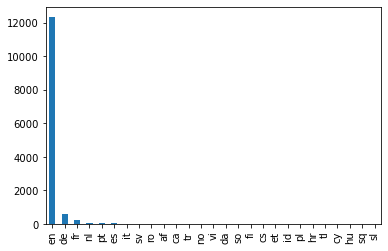

In [18]:
# Get the value counts of the 'language' column in the 'reviews' DataFrame
language_counts = reviews['language'].value_counts()

# Create a bar plot of the language counts using the 'plot.bar()' method
language_counts.plot.bar()

# Display the plot
plt.show()


In [19]:
# Make a copy of the 'reviews' DataFrame called 'reviews_en' to preserve the original DataFrame
reviews_en = reviews.copy(deep=True)

# Find the indexes of all non-English comments by using the "~" symbol to invert the Boolean values returned by the 'str.match()' method
index_nonen = reviews_en[~reviews_en['language'].str.match('en')].index

# Calculate the percentage of non-English comments by dividing the length of the 'index_nonen' list by the total number of rows in the 'reviews_en' DataFrame
nonen_percentage = len(index_nonen) / reviews_en.shape[0] * 100

# Print the percentage of non-English comments with two decimal places
print('{:.2f}% of all entries are not in English'.format(nonen_percentage))

8.92% of all entries are not in English


In [20]:
# drop
reviews_en.drop(index_nonen, inplace=True)

# Estimate polarity using VADER

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a tool for sentiment analysis built into the Natural Language Toolkit (nltk) library in Python. It is designed to identify and extract the polarity (positive, negative, or neutral) and intensity of sentiment expressed in a given piece of text, such as a sentence, paragraph, or document.

In [21]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
# test it out on first comment
def sentiment_analyzer_scores(comment):
    score = analyzer.polarity_scores(comment)
    return(pd.DataFrame.from_dict(score, orient='index'))

sentiment_analyzer_scores(reviews_en['comments'][1026])


,0
neg,0.0800
neu,0.8410
pos,0.0790
compound,-0.0083


In [23]:
# we want one overall polarity score, so just look at the 'compound' score
polarity_compound = lambda s: (analyzer.polarity_scores(s))['compound']

In [24]:
# Apply the lambda function to the 'comments' column of the 'reviews_en' dataframe
reviews_en['polarity_sentiment'] = reviews_en.comments.map(polarity_compound)

In [25]:
reviews_en[:5].style.bar(subset=['polarity_sentiment'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity_sentiment
0,3191,4888238.000000,5/31/2013,5737473,Kathleen,"Great home away from home! Bridgette and Martha were wonderful! I would recommend this place for couples, friends or family!",en,0.935700
2,3191,9924130.000000,1/20/2014,4039279,Zacki,"This cottage was a great base from which to explore the amazing city of Cape Town! It's well equipped so I felt right at home. Brigitte was an attentive, organised host and helped make my stay memorable.",en,0.883200
3,3191,16659537.000000,7/31/2014,9729939,Doug,I had a great stay. All my needs were well exceeded with warm-hearted hospitality. Would definitely stay here again.,en,0.836000
4,3191,23247470.000000,11/26/2014,9681619,Christopher,Excellent host. She provided everything we could think of during our stay. The cottage is lovely and clean and very tranquil. I would definitely stay here again.,en,0.928100
6,3191,34203620.000000,6/6/2015,30266918,Thomas,This was the perfect guest home for me to stay in whilst I was searching for a permanent home following a job transfer to Cape Town. Brigitte was warm and welcoming and made me feel at home. If you are looking for a nice play to explore Cape Town and the surrounding areas then I would definitely recommend this place!,en,0.953100


In [26]:
reviews_en[reviews_en['polarity_sentiment']<0][:5].style.bar(subset=['polarity_sentiment'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,polarity_sentiment
89,283053,8482308.000000,11/2/2013,60473,Madeleine,"We stayed in the Main floor apartment for days. The apartment is very spacious and well equipped. The location is good for exploring downtown Cape Town and the Waterfront and is also close to Sea Point. Having a car is definitely handy but there are restaurants, shops and bars within walking distance and we had no problem calling taxis when we needed them.",en,-0.434500
190,800546,26772039.000000,2/19/2015,10857358,Ivan,"I stayed at Glen Beach Villa, Apartment , for nights in February . The apartment is modern, bright and airy and is as described by the host Camps Bay in general is a fantastic place to stay when visiting Cape Town and the Glen Beach Villas are nicely situated within Camps Bay being withing walking distance of all the amenities in the area Being so close to everything, however, does have a drawback in that the apartments are situated right on Victoria Road .... the main road in and out of Camps Bay...and it is very busy and very noisy We live in a very very quite suburb in Australia and so we did find the traffic noise disturbing at times and often had the sliding doors closed which helped a lot. Other tenants we noticed did not seem to be perturbed so you would have to make your own mind on this one negative factor when considering this property",en,-0.248400
274,15480,9799711.000000,1/11/2014,9631449,Richard,"The apartment was in a great location close to all the local sights and a very good Coffee shop ""Truth"" just down the road! The pool on the roof was great and the Gym came in very handy (best life cycle view ever) The only criticism would be no view as illegal building put up directly next to apartment so you see barbed wire and concrete. Also slight problem with Cockroaches in kitchen. No wifi available which was a pain. Could use a Dongle on PC but nothing on mobile.",en,-0.237200
612,19271,672875934.000000,10/10/2020,363039461,Takalani,"The place is beautiful, but we had a serious miscommunication with the host and she was a bit harsh.",en,-0.431000
1026,811611,22019719.000000,10/28/2014,18027344,Matthias,At first many thanks to Ursula.It was the starting point of our travel an the place was just perfect.The place is very central so we could reach downtown and the waterfront without car.(very helpful when you are not familiar with left-hand driving)Ursula was always very helpful even after our stay we can contact her for hints for travelling and sightseeing.And her knowledge of Cape Town and the Garden Route was very helpful for us.We will definitely come back to you.,en,-0.008300


c:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


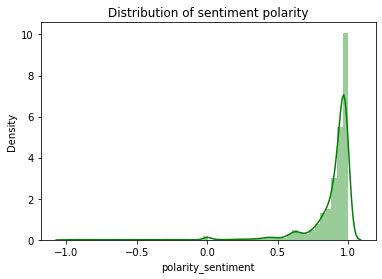

In [27]:
sns.distplot(reviews_en['polarity_sentiment'], norm_hist=True, color='g')
plt.title('Distribution of sentiment polarity');

# Build recommendation engine

In [29]:
df_rec = reviews_en[['reviewer_id', 'listing_id', 'polarity_sentiment']]

In [30]:
df_rec.nunique()

reviewer_id           11882
listing_id              283
polarity_sentiment     1959
dtype: int64

In [31]:
df_rec

,reviewer_id,listing_id,polarity_sentiment
0,5737473,3191,0.9357
2,4039279,3191,0.8832
3,9729939,3191,0.8360
4,9681619,3191,0.9281
6,30266918,3191,0.9531
...,...,...,...
13541,6695043,2037869,0.9588
13542,57739362,2037869,0.9770
13543,20256866,2037869,0.9508
13545,8843478,2037869,0.9259


There’s a key processing step we need to take before we can use our dataset for SVD: transform it into a utility matrix! A utility matrix is essentially a pivot of our 3 column dataset (reviewer_id, listing_id, polarity) into a sparse n x m table, where the axes correspond to our reviewer_id and listing_id columns, and the table is populated with polarity values for known reviewer_id/listing_id pairs and NaN if unknown. We can generate this table super easily with panda’s pivot_table function.


A utility matrix, also known as a user-item matrix, is a data structure used in recommender systems to represent the interaction between users and items. In a utility matrix, the rows correspond to the users, the columns correspond to the items, and the cells contain some measure of the user's interaction with the item, such as a rating or a binary indicator of whether the user has interacted with the item.

The utility matrix is a fundamental data structure in collaborative filtering-based recommender systems, which leverage the behavior of other users to make recommendations. 

In [33]:
# create utility matrix

matrix = df_rec.pivot_table(index='reviewer_id', columns='listing_id', values='polarity_sentiment')
matrix.head()

listing_id,3191,15007,15077,15199,15285,15480,15704,16259,19271,19384,...,2381610,2387735,2401492,2402624,2422808,2433060,2434360,2442614,2442838,2446152
reviewer_id,,,,,,,,,,,,,,,,,,,,,
3144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6282,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Extract the user IDs and item IDs from the index and column labels of the matrix
userrows = list(matrix.index)
itemcols = list(matrix.columns)

# Create a dictionary mapping user IDs to their corresponding row index in the matrix
users_index = {userrows[i]: i for i in range(len(userrows))}

# Create a dictionary mapping item IDs to their corresponding column index in the matrix
items_index = {itemcols[i]: i for i in range(len(itemcols))}


* The first line imports the SVD function from the scipy.sparse.linalg module.
* The function recommend_predictions is defined that takes in a dataframe df_rec containing polarity values for known reviewer/listing pairs, and an integer k which represents the number of features to keep for SVD. The function will return a matrix of predicted polarity values for all possible (reviewer, listing) pairs.


* This line creates a utility matrix from the input dataframe df_rec. The pivot_table() function is used to reshape the data such that the rows represent reviewers, the columns represent listings, and the values represent polarity scores.


* These lines create dictionaries reviewer_index and listing_index that map reviewer and listing IDs to their corresponding row and column indices in the utility matrix.


* These lines handle missing values (represented by NaNs) in the utility matrix by first creating a boolean mask indicating the locations of the NaNs. Then, a masked array is created using this mask, which replaces the NaNs with masked values. The mean value of each item is then computed across all reviewers to use for filling in the masked values. The utility matrix is then updated to replace the masked values with the item means. Finally, the mean is subtracted from each element of the filled utility matrix to create a demeaned utility matrix.

# Using SVD

In [99]:
from scipy.sparse.linalg import svds

# this function also incorporates creating the utility matrix and keep track of reviewer and listing IDs

def recommend_predictions(df_rec, k):
    """
    :param df_rec: dataframe with polarity values for known reviewer/listing pairs
    :param k: number of features to keep for SVD

    returns the dataframe with predicted polarity values for all (user,item) pairs
    """
    # get utility matrix
    util_mat = df_rec.pivot_table(index='reviewer_id', columns='listing_id', values='polarity_sentiment')


    # These lines create dictionaries reviewer_index and listing_index to keep track
    #  of the row and column indices respectively, using the reviewer and listing IDs.
    reviewer_rows = list(util_mat.index)
    reviewer_index = {reviewer_rows[i]: i for i in range(len(reviewer_rows))}
    listing_cols = list(util_mat.columns)
    listing_index = {listing_cols[i]: i for i in range(len(listing_cols))}

    # These lines mask NaN values in util_mat, 
    # create a masked array masked_arr using the mask, 
    # calculate the mean of the masked array masked_arr along the columns,
    #  fill the masked array masked_arr with these column means, 
    # create an array of the same shape as util_mat with the column means means, 
    # and demean util_mat by subtracting the means array from it.mask = np.isnan(util_mat)
    masked_arr = np.ma.masked_array(util_mat, mask)
    item_means = np.mean(masked_arr, axis=0) 
    util_mat = masked_arr.filled(item_means)
    means = np.tile(item_means, (util_mat.shape[0],1))
    util_mat_demeaned = util_mat - means

    # These lines perform Singular Value Decomposition (SVD) on the demeaned utility matrix util_mat_demeaned  
    # using the svds function with the specified number of features k. 
    # It returns the matrices U, sigma, and Vt. The sigma matrix is converted to a diagonal matrix using np.diag. 
    # The predicted polarity values for all (reviewer,listing) pairs are calculated as the dot product of the 
    # U, sigma, and Vt matrices, with the means array added back.
    
    U, sigma, Vt = svds(util_mat_demeaned, k = k)
    sigma = np.diag(sigma)  
    all_predicted_polarity = np.dot(np.dot(U, sigma), Vt) + means

    return all_predicted_polarity, reviewer_index, listing_index

In [109]:
# pred is a numpy array of predicted polarity values for all (user, item) pairs.
pred = recommend_predictions(df_rec, k=50)


In [101]:
# evaluation on known reviewer-listing pairs
this_pred = [] # create an empty list to store the predicted ratings

# iterate through each row of the dataframe
for i, row in df_rec.iterrows():
    user = row['reviewer_id'] # get the reviewer ID for the current row
    item = row['listing_id'] # get the listing ID for the current row
    
    try:
        # look up the index of the user in the user_index dictionary
        u_index = users_index[user]
        
        # check if the item is in the item_index dictionary
        if item in items_index:
            # look up the index of the item in the item_index dictionary
            i_index = items_index[item]
            # use the predicted rating for the user-item pair from the prediction matrix
            pred_rating = pred[u_index, i_index]
        else:
            # if the item is not in the item_index dictionary, use the average rating of the user across all items
            pred_rating = np.mean(svd[u_index, :])
        
        # add the predicted rating to the list of predicted ratings for the current iteration
        this_pred.append(pred_rating)
        
    except:
        # if there is an error with the current user, print an error message
        print('error with user', user, 'at index', i)


This code calculates the root mean squared error (RMSE) between the actual polarity sentiment ratings and the predicted ratings obtained from the recommendation model. RMSE is a commonly used metric to evaluate the performance of recommendation models. It gives an idea of how well the model is able to predict the ratings for the known reviewer-listing pairs in the dataset.

In [102]:
rmse = math.sqrt(mean_squared_error(df_rec['polarity_sentiment'], this_pred))
print(rmse)

0.11030377690362399


Hyperparam optimization: k, the number of features into which each user and movie will be resolved into

In [107]:
# try different values of k

no_of_features = [70, 100, 120, 150]
rmse= []

for k in no_of_features:
    pred_out, _, _ = recommend_predictions(df_rec, k=k)
    
    this_pred = [] #to store the predicted ratings
    for i, row in df_rec.iterrows():
        user = row['reviewer_id']
        item = row['listing_id']

        try:
            u_index = users_index[user]
            if item in items_index:
                i_index = items_index[item]
                pred_rating = pred_out[u_index, i_index]
            else:
                pred_rating = np.mean(svds[u_index, :])
            this_pred.append(pred_rating)

        except:
            print('error with user', user, 'at index', i)
            continue

    rmse_i = math.sqrt(mean_squared_error(df_rec['polarity_sentiment'], this_pred))
    rmse.append(rmse_i)
    
    print(f'The k value: ', k,'and the RMSE score is ' ,rmse_i)

The k value:  {70} and the RMSE score is  0.09166791652697484
The k value:  {100} and the RMSE score is  0.06765832883534578
The k value:  {120} and the RMSE score is  0.0541654302240435
The k value:  {150} and the RMSE score is  0.04047414152210097


The Lower the RMSE the better the model

# getting the recommendation

In [113]:
u_index = users_index[df_rec['reviewer_id'][2]]
pred_user = [predMat[u_index, i_index] for i_index in item_i]

1455

In [111]:
# extract all unique listing ids from the recommendations dataframe
listing_id_array = df_rec['listing_id'].unique()

def get_recommendations(predMat, reviewer, N):
    """
    predMat: predicted matrix, svds
    reviewer: selected reviewer_id
    N: top N recommendations
    
    return top N recommendations for specified user
    """
    # get the user index from the users_index dictionary
    u_index = users_index[reviewer]
    
    # get the item indices for all unique listings
    item_i = [items_index[listing_id_array[i]] for i in range(len(listing_id_array))]
    
    # get the predicted ratings for the specified user and all items
    pred_user = [predMat[u_index, i_index] for i_index in item_i]
    
    # create a dataframe with listing ids and predicted ratings for the specified user
    d = {'listing_id': listing_id_array, 'predicted_polarity': pred_user}
    user_rec = pd.DataFrame(data=d)
    
    # sort the dataframe by predicted ratings in descending order
    user_rec.sort_values(by=['predicted_polarity'], ascending=False, inplace=True)
    
    # reset the index of the dataframe
    user_rec.reset_index(inplace=True, drop=True)
    
    # return the top N recommendations for the specified user
    return user_rec[:N]


In [97]:
# using mat from SVD method
svdout, reviewer_index, listing_index = recommend_predictions(df_rec, k=150)
user_rec = get_recommendations(svdout, df_rec['reviewer_id'][2], 50)
user_rec.style.bar(subset=['predicted_polarity'], align='mid', color=['#d65f5f', '#5fba7d'])

,listing_id,predicted_polarity
0,565844,0.990700
1,141734,0.990500
2,474596,0.989650
3,1643095,0.989600
4,518726,0.984550
5,1796238,0.983360
6,1005168,0.979814
7,1863625,0.978500
8,469356,0.975767
9,1942398,0.975167
